# Preprocessing Notebook

## Data Input preparation Ground Truth masks creation, Subsets Resampling 
    Notebook's objective focus on all subsets preprocessing. Including ground truth mask creation for each subset's sequences to the resampling of both the mask and data volume (according to the standard dimension/size previously defined). 

In [2]:
import os
import json
import warnings
import pydicom
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import ast
import SimpleITK as sitk
import nibabel as nib
import tensorflow as tf
print('tf:',tf.__version__)

tf: 2.10.0


### Base paths and Metadata

In [3]:
test_path ='C:/Users/Eduardo/Desktop/DataOrtho/DATASET_AXIAL/24/LEFT/pd_tse_fs_tra_13/'
groundTruth_path = 'C:/Users/Eduardo/Desktop/DataOrtho GroundTruth'
base_path = 'C:/Users/Eduardo/Desktop/DataOrtho'
resampling_path = 'C:/Users/Eduardo/Desktop/DataOrtho_Resampled/Linear Interpolation/'

#axial
resampled_path_axial_linear = 'C:/Users/Eduardo/Desktop/DataOrtho_Resampled/Linear Interpolation/DATASET_AXIAL'
axial_path_gt = 'C:/Users/Eduardo/Desktop/DataOrtho GroundTruth/DATASET_AXIAL'

#sagittal
sagittal_path_gt = 'C:/Users/Eduardo/Desktop/DataOrtho GroundTruth/DATASET_SAGITTAL'

#dynamic
dynamic_path_gt = 'C:/Users/Eduardo/Desktop/DataOrtho GroundTruth/DATASET_DYNAMIC'


excel_paths = {'DATASET_AXIAL': 'C:/Users/Eduardo/Desktop/DataOrtho/DATASET_AXIAL/dataset_axial.xlsx', 
                            'DATASET_SAGITTAL': 'C:/Users/Eduardo/Desktop/DataOrtho/DATASET_SAGITTAL/dataset_sagittal.xlsx',
                            'DATASET_DYNAMIC': 'C:/Users/Eduardo/Desktop/DataOrtho/DATASET_DYNAMIC/dataset_dynamic.xlsx'}

subsets_metadata_paths = {'DATASET_AXIAL': 'metadata/after_validation_pixelData/axial_subset_metadata_validated.csv', 
                            'DATASET_SAGITTAL': 'metadata/after_validation_pixelData/sagittal_subset_metadata_validated.csv',
                            'DATASET_DYNAMIC': 'metadata/after_validation_pixelData/dynamic_subset_metadata_validated.csv'}


list_size = {'DATASET_AXIAL': [256,256,32], 
                            'DATASET_SAGITTAL': [256,256,32],
                            'DATASET_DYNAMIC': [256,256,64]}

axial_landmarks = pd.read_excel(excel_paths['DATASET_AXIAL'])
axial_metadata = pd.read_csv('metadata/after_validation_pixelData/axial_subset_metadata_validated.csv')

### Help functions

#### GroundTruth and Masks creation visualization

In [4]:
#---------- 4D (channels dimension) Visualization ----------#
    
def visualize_montage_mri_4D_channel(mri_volume,heatmaps_masks,channel, start_slice, end_slice, step=1):
    num_landmarks = heatmaps_masks.shape[-1] 
    
    fig, axarr = plt.subplots(1, (end_slice - start_slice) // step, figsize=(20, 5*num_landmarks))
    
    max_intensity_idx = np.unravel_index(np.argmax(heatmaps_masks[..., channel]), heatmaps_masks[..., channel].shape)
    print('max intensity idx: ',max_intensity_idx)
    
    print('Intensity masks: ', heatmaps_masks[max_intensity_idx[0],max_intensity_idx[1],max_intensity_idx[2], channel])
    print('Intensity volume: ', mri_volume[max_intensity_idx[0],max_intensity_idx[1],max_intensity_idx[2]])

    print(f"Channel {channel} has maximum intensity at slice: {max_intensity_idx[2]}")
    for i, idx in enumerate(range(start_slice, end_slice, step)):
        axarr[i].imshow(mri_volume[:, :, idx], cmap='gray')  # MRI in grayscale
        axarr[i].imshow(heatmaps_masks[:, :, idx, channel], cmap='jet', alpha=0.5,vmin = 0, vmax=1 )  # specific landmark heatmap overlay
        axarr[i].axis('off')
        if i == 0:
            if channel == num_landmarks - 1:
                axarr[i].set_ylabel(f'Background')
            else:
                axarr[i].set_ylabel(f'Landmark {channel + 1}')
            
        axarr[i].set_title(f'Slice: {idx}')
        
    plt.tight_layout()
    plt.show()
    
def visualize_specific_slice_4Dmask(slice_idx,channel,mri_volume, heatmaps_channel):
    fig, axarr = plt.subplots(1, figsize=(16, 8))
    axarr.imshow(mri_volume[:,:,slice_idx],cmap='gray')
    axarr.imshow(heatmaps_channel[:, :, slice_idx, channel], cmap='jet', alpha=0.5,vmin = 0, vmax=1)
    axarr.set_title(f'Slice: {slice_idx}')
    plt.show()

# Resampling Visualization
def compare_slices_by_proportion(original_volume, resampled_volume, proportion):
    # Compute the slice index based on the proportion for both volumes
    orig_slice_idx = int(proportion * (original_volume.shape[2] - 1))
    resamp_slice_idx = int(proportion * (resampled_volume.shape[2] - 1))
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    # Display the original slice
    ax1.imshow(original_volume[:, :, orig_slice_idx], cmap='gray')
    ax1.set_title('Original Volume - Slice {}'.format(orig_slice_idx))
    ax1.axis('off')
    
    # Display the resampled slice
    ax2.imshow(resampled_volume[:, :, resamp_slice_idx], cmap='gray')
    ax2.set_title('Resampled Volume - Slice {}'.format(resamp_slice_idx))
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()

# string coeherence
def refactor_path(path_example):
    return path_example.replace("\\", "/")


#### Important functions for mask creation

**validate_dicom_image_data** - try to read a DICOM file. Return False if there's an error, method for obtaining correct num_slices

**read_dicom_sequence** - Read a DICOM sequence from a directory: returns 3D numpy array (path: directory containing DICOM files for a sequence.)

**get_sequence_properties** - Excel row matching with sequence_path: returns sequence metadata and groundtruth landmarks

In [6]:
def validate_dicom_image_data(file_path):
    try:
        dc = pydicom.dcmread(file_path)
        if 'PixelData' in dc:
            return True
        else:
            return False
    except:
        return False
    
def read_dicom_sequence(path):
    dicom_files = [pydicom.dcmread(os.path.join(path, f),force=True) for f in os.listdir(path) if f.endswith('.dcm') and validate_dicom_image_data(os.path.join(path, f))]
    dicom_files.sort(key=lambda x: int(getattr(x, "InstanceNumber", 99999)))
    #3D numpy array representing the MRI sequence.
    return np.stack([df.pixel_array for df in dicom_files], axis=2)


# sequence path test of 24/LEFT/pd_tse_fs_tra_13
# return list of data from the excel
def get_sequence_properties(sequence_path,groundTruthFlag = 0):
    # define the regex pattern
    if groundTruthFlag == 0:
        pattern = r"(?P<Dataset>DATASET_\w+)[\\/](?P<Individual>\d+)[\\/](?P<Knee>LEFT|RIGHT)[\\/](?P<Sequence>[\w+]+)[\\/]*"
    
    else:
        pattern = r"(?P<Dataset>DATASET_\w+)[\\/](?P<Type>)(Masks|Volumes)[\\/](?P<Individual>\d+)[\\/](?P<Knee>LEFT|RIGHT)[\\/](?P<Sequence>[\w+]+)[\\/]*"
    # using regex pattern
    match = re.search(pattern, sequence_path)
    # matched groups as a dictionary if true
    sequence_metadata = match.groupdict()
    # dynamic on the sequence path
    excel_file_path = excel_paths[sequence_metadata.get('Dataset')]  
    
    try:
        subset_df = pd.read_excel(excel_file_path,engine='openpyxl')
        matching_rows = (subset_df["Individual"] == int(sequence_metadata.get('Individual'))) & (subset_df["Sequence"] == sequence_metadata.get('Sequence')) & (subset_df["Knee"] == sequence_metadata.get('Knee'))
        sequence_row = subset_df[matching_rows]

        landmarks = ast.literal_eval(sequence_row['Landmarks'].iloc[0])
        return sequence_metadata, landmarks
    
    except Exception as e:
            print(f"Failed to extract sequence landmarks from Excel  due to: {e}")

def ensure_directory_exists(directory_path):
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)


## Ground Truth Creation Process

### Gaussian Masks creation

**create_gaussian_mask3D** - Generates 3D Gaussian mask spread along different slices

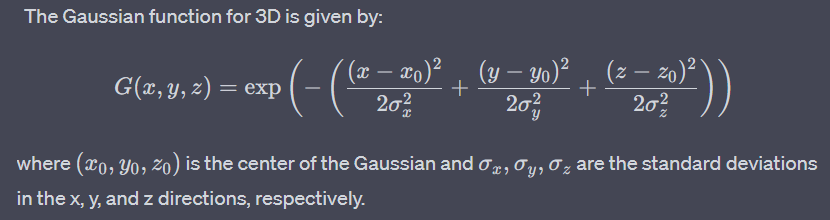

In [5]:
def create_gaussian_mask3D(size,center,sigma_x,sigma_y, sigma_z):
    x = np.arange(0, size[0], 1, float)
    y = np.arange(0, size[1], 1, float)
    # z will be the number of slices of the volume, the mask will be created on the full depth of the volume
    z = np.arange(0, size[2], 1, float)
    
    x0, y0, z0 = center
    
    x, y, z = np.meshgrid(x, y, z, indexing='ij')
    
    gaussian = np.exp(-((x - x0) ** 2 / (2 * sigma_x ** 2)
                    + (y - y0) ** 2 / (2 * sigma_y ** 2) 
                    + (z - z0) ** 2 / (2 * sigma_z ** 2)))
    gaussian_norm = gaussian / np.max(gaussian)
    return gaussian_norm

#### **create_3Dmasks_on_mri_background** - introduction of the background mask

Detail: the landmarks were stored with  (width,height)

In [6]:
def percentage(percent, whole):
  return (percent * whole) / 100.0

def create_3Dmasks_on_mri_background(sequence_path,sequence_metadata,landmarks,percentageSigma):
    # fetch rows e columns from csv metadata
    # to pass them to the create_gaussian_mask
    goal_metadata = pd.read_csv(subsets_metadata_paths[sequence_metadata['Dataset']])
    
    meta = ((goal_metadata['Individual'] == int(sequence_metadata['Individual'])) & (goal_metadata['Knee'] == sequence_metadata['Knee']) & (goal_metadata['Sequence'] == sequence_metadata['Sequence']))
    sequence = goal_metadata[meta]
    sequence_size = [sequence['Rows'].iloc[0],sequence['Columns'].iloc[0],sequence['Num_Slices'].iloc[0]]
    
    try:
        sigma_x= percentage(percentageSigma,sequence_size[0])
        sigma_y = percentage(percentageSigma,sequence_size[1])
        sigma_z = percentage(percentageSigma,sequence_size[2])
    
        #print('Sequence',sequence_size)
        #print('sigmas:',sigma_x,sigma_y,sigma_z)
        # read the MRI sequence -> Create the 3D volume
        mri_sequence = read_dicom_sequence(sequence_path).astype(np.float32)
        # heatmaps array witht the masks
        heatmaps_masks = np.zeros((*mri_sequence.shape, len(landmarks))) #(height, width, depth, N_l) 
        
        # generate the masks for each landmark
        sorted_landmarks = sorted(landmarks, key=lambda x: x[2])
        for id, landmark in enumerate(sorted_landmarks):
            y, x, _, z = landmark # landmarks were (width,height)  
            #print(x, y, _, z)
            center = (int(x), int(y), int(z))
            gaussian_mask = create_gaussian_mask3D(sequence_size, center,sigma_x,sigma_y,sigma_z)
            heatmaps_masks[:, :, :, id] = gaussian_mask 
        

        background_heatmap = np.ones_like(mri_sequence) - heatmaps_masks.sum(axis=-1) #(height, width, depth)
        # clip the background heatmap so that negative values cease to exist
        background_heatmap = np.clip(background_heatmap, 0, None)
        
        # append the background heatmap to the 4D heatmap array
        # taking the 3D background_heatmap and adding a new axis to it to make it 4D. 
        # shape of background_heatmap:(height, width, depth), to (height, width, depth, 1).
        heatmaps_masks  = np.concatenate([heatmaps_masks, background_heatmap[..., np.newaxis]], axis=-1) # (height, width, depth, N_l+1)
        
        # ensure float32 byte size to avoid corrupted errors on training
        mri_sequence = mri_sequence.astype(np.float32)
        heatmaps_masks = heatmaps_masks.astype(np.float32)

        return mri_sequence, heatmaps_masks
    
    except Exception as e:
        print(f"Failed to create 3D Mask on the MRI sequence due to: {e}")

##### Single sequence Gaussian Masks creation Test

In [7]:
axial_path = 'C:/Users/Eduardo/Desktop/DataOrtho/DATASET_AXIAL/3/LEFT/pd_tse_fs_tra_320_3'
sequence_metadata,test_path_landmarks = get_sequence_properties(axial_path)
sequence_metadata

{'Dataset': 'DATASET_AXIAL',
 'Individual': '3',
 'Knee': 'LEFT',
 'Sequence': 'pd_tse_fs_tra_320_3'}

In [ ]:
sagittal_path = 'C:/Users/Eduardo/Desktop/DataOrtho/DATASET_SAGITTAL/12/LEFT/t1_tse_SAG_4'
sagittal_path2 = 'C:/Users/Eduardo/Desktop/DataOrtho/DATASET_SAGITTAL/2/RIGHT/t1_tse_sag_4'
sequence_metadata,test_path_landmarks = get_sequence_properties(sagittal_path)
sequence_metadata

In [8]:
mri_volume, masks = create_3Dmasks_on_mri_background(axial_path,sequence_metadata,test_path_landmarks,3)

In this test path landmarks there are:

- 2 lm: slice 6
- 5 lm: slice 11
- 2 lm: slice 20
- 1 lm: slice 19
- 1 lm: slice 27

max intensity idx:  (0, 0, 0)
Intensity masks:  1.0
Intensity volume:  0.0
Channel 11 has maximum intensity at slice: 0


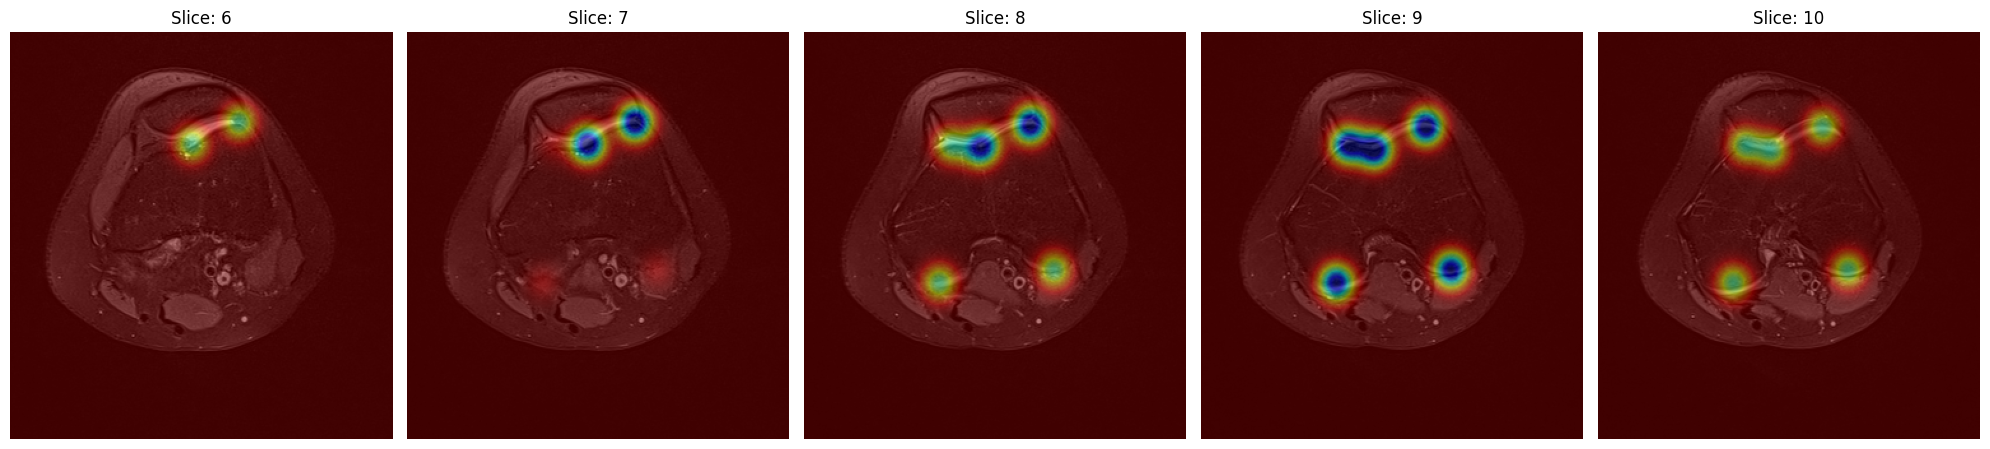

In [12]:
visualize_montage_mri_4D_channel(mri_volume,masks,11,6,11)

In [ ]:
# 216.06797575754285 99.45091804199295
visualize_specific_slice_4Dmask(14,0,mri_volume,masks)

### Ground truth creation methods

Neuroimaging Informatics Technology Initiative (NIfTI format)  [.nii or .nii.gz]

- Format is widely used in medical imaging. 
- Allows storage of metadata along with the 3D volume data.
- nibabel librarie can be used to save and load NIfTI files in Python.

Pipeline of Mask creation for an entire subset (the use of the previous implemented functions):
- Get metadata 
- Get landmarks
- Create masks
- Save them volumes & masks

**save_mask_nifti** - save 3D volume data into file, 3D volume or correspondent mask

**ensure_directory_exists** - verification if dir exists, if not then create one

**create_masks_subset** - creation of full mask volumes for a subset: AXIAL, SAGITTAL or DYNAMIC

In [7]:
def save_volume_nifti(data, file):
    # no transformation, so we use identity matrix: eye method
    img = nib.nifti1.Nifti1Image(data,np.eye(4)) # after reampling what happens?
    img.to_filename(file)

def create_masks_subset(subset_path,subset_path_gt):
    total_sequences = 0  
    if os.path.isdir(subset_path):
        # individuals
        for individual in os.listdir(subset_path):
            individual_path = os.path.join(subset_path, individual)
            
            individual_path_gt_volumes = os.path.join(subset_path_gt,'Volumes',individual)
            individual_path_gt_masks = os.path.join(subset_path_gt,'Masks',individual)
            # if not existent create them dirs
            #ensure_directory_exists(individual_path_gt_volumes)
            #ensure_directory_exists(individual_path_gt_masks)
            if os.path.isdir(individual_path):
                # knees
                for knee in os.listdir(individual_path):
                    knee_path = os.path.join(individual_path, knee)
                    # sequences
                    for sequence in os.listdir(knee_path):
                        sequence_path = os.path.join(knee_path, sequence)
                        try:
                            # sequence metadata and respective landmarks for mask creation
                            sequence_metadata,test_path_landmarks = get_sequence_properties(sequence_path)
                            # MRI volume with the landmarks overlaid for visualization purposes, 3D mask for the volume and mask list for debug
                            mri_sequence, mask3D = create_3Dmasks_on_mri_background(sequence_path,sequence_metadata,test_path_landmarks,3)
                            
                            directory_vol= os.path.join(individual_path_gt_volumes, knee, sequence)
                            directory_masks = os.path.join(individual_path_gt_masks, knee, sequence)


                            ensure_directory_exists(directory_vol)
                            ensure_directory_exists(directory_masks)
                            # save paths for both volume and mask
                            save_path_volume = os.path.join(directory_vol, sequence + ".nii")
                            save_path_mask = os.path.join(directory_masks, sequence + "_mask.nii.gz")
                            
                            #save both 3D volumes, mri and correspondent mask
                            save_volume_nifti(mri_sequence, save_path_volume)
                            save_volume_nifti(mask3D, save_path_mask)
                            
                            total_sequences += 1
                        except Exception as e:
                            print(f"Failed to create Masks and Volume on the MRI sequence {sequence_path} due to: {e}")
                            
    print('Total created mask Sequences: ', total_sequences)
                                                  

#### Axial Gt creation

In [8]:
axial_path = 'C:/Users/Eduardo/Desktop/DataOrtho/DATASET_AXIAL/'
axial_path_gt = 'C:/Users/Eduardo/Desktop/DataOrtho GroundTruth/DATASET_AXIAL'

In [22]:
create_masks_subset(axial_path,axial_path_gt)

Total created mask Sequences:  234


##### Axial Gt test

In [ ]:
axial_path_volume = 'C:/Users/Eduardo/Desktop/DataOrtho GroundTruth/DATASET_AXIAL/Volumes/67/RIGHT/AXIAL_DP_FS_MTC_4/AXIAL_DP_FS_MTC_4.nii'
axial_path_masks = 'C:/Users/Eduardo/Desktop/DataOrtho GroundTruth/DATASET_AXIAL/Masks/67/RIGHT/AXIAL_DP_FS_MTC_4/AXIAL_DP_FS_MTC_4_mask.nii.gz'

In [ ]:
axial_volume, axial_mask = read_nifti_sequence(axial_path_volume,axial_path_masks) 

In [ ]:
axial_volume = np.transpose(axial_volume)
axial_mask= np.transpose(axial_mask)

In [ ]:
visualize_montage_mri_4D_channel(axial_volume, axial_mask,3,2,20)

#### Sagittal Gt creation

In [6]:
sagittal_path = 'C:/Users/Eduardo/Desktop/DataOrtho/DATASET_SAGITTAL/'
sagittal_path_gt = 'C:/Users/Eduardo/Desktop/DataOrtho GroundTruth/DATASET_SAGITTAL'

In [ ]:
create_masks_subset(sagittal_path,sagittal_path_gt)

##### Sagittal Gt test

In [ ]:
sagittal_path_volume = 'C:/Users/Eduardo/Desktop/DataOrtho GroundTruth/DATASET_SAGITTAL/Volumes/12/LEFT/t1_tse_SAG_4/t1_tse_SAG_4.nii'
sagittal_path_masks = 'C:/Users/Eduardo/Desktop/DataOrtho GroundTruth/DATASET_SAGITTAL/Masks/12/LEFT/t1_tse_SAG_4/t1_tse_SAG_4_mask.nii.gz'

In [ ]:
sagittal_volume, sagittal_mask = read_nifti_sequence(sagittal_path_volume,sagittal_path_masks) 

In [ ]:
sagittal_volume.shape

In [ ]:
sagittal_mask.shape

In [ ]:
inspect_data(sagittal_mask,'mask')

In [ ]:
sagittal_volume = np.transpose(sagittal_volume)
sagittal_mask= np.transpose(sagittal_mask)

In [ ]:
visualize_montage_mri_4D_channel(sagittal_volume,sagittal_mask,2,2,20)

In [ ]:
visualize_specific_slice_4Dmask(12,3,mri_volume,masks)

#### Dynamic Gt creation

In [7]:
dynamic_path = 'C:/Users/Eduardo/Desktop/DataOrtho/DATASET_DYNAMIC/'
dynamic_path_gt = 'C:/Users/Eduardo/Desktop/DataOrtho GroundTruth/DATASET_DYNAMIC'

In [ ]:
create_masks_subset(dynamic_path,dynamic_path_gt)

## Resampling Process

    Resample all volumes and masks created at Ground Truth creation step with the desired size and save the resampled outcome into Resampled path. After resampling convert into desired format for modeling

References:
- https://simpleitk.readthedocs.io/en/master/IO.html
- https://blog.tensorflow.org/2018/07/an-introduction-to-biomedical-image-analysis-tensorflow-dltk.html


**read_nifti_sequence** - returns the np.ndarray of both volume and masks nifti file associated with the sequence. Used for resampling task

**resample_sequence** - Resample the DICOM volume and the correspondent ground truth at the given volume and masks path to a new spacing. Using sitk library to load the .nii and .nii.gz files 

**resample_subset** - resample function called for each sequence in the required subset

**check_resample_subset** - check if files are resampled

In [7]:
def read_nifti_sequence(volume_path, masks_path):
    # read image from the vol and mask path
    sitk_volume = sitk.ReadImage(volume_path)
    sitk_masks = sitk.ReadImage(masks_path)
    # get array from each
    volume = sitk.GetArrayFromImage(sitk_volume)
    masks= sitk.GetArrayFromImage(sitk_masks)

    # shape does not come as in numpy, simpleITK uses a different convention for image axes than numpy does so transpose in necessary
    # if we not running on the resampling_sequence
    return volume,masks

def resample_sequence(volume_path,masks_path,desired_size, interpolator=sitk.sitkLinear):
    # interpolator (SimpleITK interpolator, optional) - interpolation method to use, default being sitk.sitkLinear
    volume, masks = read_nifti_sequence(volume_path,masks_path)
    # create the sitk image from np array volume, where we get the correspondent metadata to create the new_size and to fill execute call    
    sitk_volume = sitk.GetImageFromArray(volume)
    
    # filter
    resampler = sitk.ResampleImageFilter()
    orig_spacing = sitk_volume.GetSpacing()
    orig_size = sitk_volume.GetSize()

    # computation new size based on the desired new_spacing, maintaining the physical size  
    new_spacing = [orig_spacing[i] * (orig_size[i] / desired_size[i]) for i in range(3)]
    
    # using linear interpolation
    resampler.SetOutputSpacing(new_spacing)
    resampler.SetSize(desired_size)
    resampler.SetOutputDirection(sitk_volume.GetDirection())
    resampler.SetOutputOrigin(sitk_volume.GetOrigin())
    resampler.SetTransform(sitk.Transform())
    resampler.SetInterpolator(interpolator)
    resampler.SetDefaultPixelValue(0)
    
    # Resample the volume
    resampled_volume = resampler.Execute(sitk_volume)
    resampled_volume = sitk.GetArrayFromImage(resampled_volume)
    # since the shape of mask is  (height,width,depth,n_channels) we are going to resample a 4D Mask 
    # with sitk.ReadImage not just reading the pixel/voxel values but also the associated metadata. 
    # metadata includes important information like the origin, spacing, and direction of the image.    
    # SimpleITK and numpy have different conventions for image axes, we must return and work with the correct axes
    
    n_channels = masks.shape[0]
    resampled_masks = []
    for i in range(n_channels):
        sitk_mask_channel = sitk.GetImageFromArray(masks[i,...])
        resampled_mask_channel = resampler.Execute(sitk_mask_channel)
        resampled_masks.append(sitk.GetArrayFromImage(resampled_mask_channel))
    
    resampled_masks = np.stack(resampled_masks,axis=-1)
    #resampled_volume = np.transpose(resampled_volume)
    

    # first axis (0) of resampled_masks is depth (axial ex:32), which should be the third axis in the desired shape.
    # second axis (1) is height (axial ex:256), which should remain as the first axis.
    # third axis (2) is width (axial ex:256), which should be the second axis.
    # fourth axis (3) is the channels (depending on the typoe of dataset), which should remain as the fourth axis.
    #print('before np transpose',resampled_masks.shape)
    # resampled_masks = np.transpose(resampled_masks, (2, 1, 0, 3))

    return resampled_volume, resampled_masks

def resample_subset(resampled_path,subset_path, interpolatorFlag):
    # resampled_path already interpolation and subset folder
    total_resampled = 0
    if not os.path.isdir(subset_path):
        print(f"Error: {subset_path} is not a directory!")
        return
    
    if interpolatorFlag == 0:
        interpolator= sitk.sitkLinear
    else:
        interpolator = sitk.sitkNearestNeighbor
    
    # volumes and mask directories from GT

    gt_path_volumes = os.path.join(subset_path, 'Volumes')
    resampled_path_volume = os.path.join(resampled_path, 'Volumes')
    
    gt_path_masks = os.path.join(subset_path, 'Masks')
    resampled_path_masks = os.path.join(resampled_path, 'Masks')

    ensure_directory_exists(resampled_path_volume)
    ensure_directory_exists(resampled_path_masks)
    
    for individual in os.listdir(gt_path_volumes):
        individual_gt_volumes = os.path.join(gt_path_volumes, individual)
        individual_resampled_volumes = os.path.join(resampled_path_volume, individual) 
        
        individual_gt_masks = os.path.join(gt_path_masks,individual)
        individual__resampled_masks = os.path.join(resampled_path_masks,individual)
        
        
        for knee in os.listdir(individual_gt_volumes):
            knee_gt_volumes = os.path.join(individual_gt_volumes, knee)
            knee_resampled_volumes = os.path.join(individual_resampled_volumes, knee)
            
            knee_gt_masks = os.path.join(individual_gt_masks, knee)
            knee_resampled_masks = os.path.join(individual__resampled_masks, knee)
            #sequences
            for sequence in os.listdir(knee_gt_volumes):  
                sequence_gt_volume= os.path.join(knee_gt_volumes, sequence)
                sequence_resampled_volume = os.path.join(knee_resampled_volumes, sequence)
                
                sequence_gt_masks = os.path.join(knee_gt_masks, sequence)
                sequence_resampled_masks = os.path.join(knee_resampled_masks, sequence)
                    
                for file in os.listdir(sequence_gt_volume):
                    if file.endswith('.nii') or file.endswith('.nii.gz'):
                        try:
                            sequence_metadata, _ = get_sequence_properties(sequence_gt_volume,1)
                            desired_size = list_size[sequence_metadata.get('Dataset')]
                            volume_gt_path = os.path.join(sequence_gt_volume,file)
                            masks_gt_path = os.path.join(sequence_gt_masks,sequence + "_mask.nii.gz") 
                            resampled_volume, resampled_masks = resample_sequence(volume_gt_path,masks_gt_path,desired_size,interpolator)
                            #print('Resampling: ', volume_gt_path, masks_gt_path)
                            
                            # save paths for both volume and mask
                            save_path_resampled_volume = os.path.join(sequence_resampled_volume,sequence +".nii.gz")
                            save_path_resampled_masks = os.path.join(sequence_resampled_masks, sequence + "_mask.nii.gz")
                            #print('Saving resampled into: ', save_path_resampled_volume, save_path_resampled_masks)
                            
                            ensure_directory_exists(sequence_resampled_volume)
                            ensure_directory_exists(sequence_resampled_masks)

                            #save both 3D volumes, mri and correspondent mask
                            save_volume_nifti(resampled_volume, save_path_resampled_volume)
                            save_volume_nifti(resampled_masks, save_path_resampled_masks)
                            total_resampled+=1
                        except Exception as e:
                            print(f"Exception made on resample_subset! Failed to resample the sequence {sequence_gt_volume} due to: {e}")
    print(f"Total resampled sequences: {total_resampled}")

def check_resample_subset(resampled_path):
    if not os.path.isdir(resampled_path):
        print(f"Error: {resampled_path} is not a directory!")
        return
    
    resampled_path_volume = os.path.join(resampled_path, 'Volumes')
    resampled_path_masks = os.path.join(resampled_path, 'Masks')

    volumes_shapes = {}
    masks_shapes = {}
    
    for individual in os.listdir(resampled_path_volume):
        individual_resampled_volumes = os.path.join(resampled_path_volume, individual) 
        individual__resampled_masks = os.path.join(resampled_path_masks,individual)
        
        
        for knee in os.listdir(individual_resampled_volumes):
            knee_resampled_volumes = os.path.join(individual_resampled_volumes, knee)
            knee_resampled_masks = os.path.join(individual__resampled_masks, knee)
            #sequences
            for sequence in os.listdir(knee_resampled_volumes):  
                sequence_resampled_volume = os.path.join(knee_resampled_volumes, sequence)
                sequence_resampled_masks = os.path.join(knee_resampled_masks, sequence)
                    
                for file in os.listdir(sequence_resampled_volume):
                    if file.endswith('.nii') or file.endswith('.nii.gz'):
                        try:
                            save_path_resampled_volume = refactor_path(os.path.join(sequence_resampled_volume,sequence + ".nii.gz"))
                            save_path_resampled_masks = refactor_path(os.path.join(sequence_resampled_masks, sequence + "_mask.nii.gz"))
                            #print(file,save_path_resampled_masks)


                            path_volume, path_mask = read_nifti_sequence(save_path_resampled_volume,save_path_resampled_masks)

                            
                            if path_volume.shape in volumes_shapes.keys():
                                volumes_shapes[path_volume.shape] = volumes_shapes[path_volume.shape] + 1
                            else:
                                volumes_shapes[path_volume.shape] = 1

                            if path_mask.shape in masks_shapes.keys():
                                masks_shapes[path_mask.shape]= masks_shapes[path_mask.shape] + 1
                            else:
                                masks_shapes[path_mask.shape] = 1
                        except Exception as e:
                            print(f"Exception made on check_resample_subset!  {save_path_resampled_volume} due to: {e}")

    return volumes_shapes,masks_shapes


### Axial Resample

In [25]:
resample_subset(resampled_path_axial_linear,axial_path_gt, 0)

Total resampled sequences: 234


In [ ]:
volumes_shape_axial_count, masks_shapes_axial_count = check_resample_subset(resampled_path_axial_linear)
print(volumes_shape_axial_count)
print(masks_shapes_axial_count)

### Sagittal Resample

In [ ]:
resample_subset(resampled_path_sagittal_linear,sagittal_path_gt, 0)

##### Sagittal resample validation

In [ ]:
sagittal_path_vol = 'C:/Users/Eduardo/Desktop/DataOrtho_Resampled/Linear Interpolation/DATASET_SAGITTAL/Volumes/12/LEFT/t1_tse_SAG_4/t1_tse_SAG_4.nii'
sagittal_path_mask = 'C:/Users/Eduardo/Desktop/DataOrtho_Resampled/Linear Interpolation/DATASET_SAGITTAL/Masks/12/LEFT/t1_tse_SAG_4/t1_tse_SAG_4_mask.nii'

In [ ]:
sag_vol,sag_mask = read_nifti_sequence(sagittal_path_vol,sagittal_path_mask)

In [ ]:
sag_mask.shape

### Dynamic Resample

In [ ]:
resample_subset(resampled_path_dynamic_linear,dynamic_path_gt, 0)

In [ ]:
volumes_shape_dynamic_count, masks_shapes_dynamic_count = check_resample_subset(resampled_path_dynamic_linear)
print(volumes_shape_dynamic_count,masks_shapes_dynamic_count)

----------------------------------------------------------------------------------------

## NifTI to TFRecord Database

**convert_resampled_to_tfrecord** - more direct approach, after resampled the volume + mask are constructed into a tfrecord tuple representive of both volume and gt mask

In [8]:
serialized_path = 'C:/Users/Eduardo/Desktop/DataOrtho_Serialized/'

def inspect_data(data, label):
    print(f"Inspecting {label}:")
    print(f"Shape: {data.shape}, Dtype: {data.dtype}")
    print(f"Max: {np.max(data)}, Min: {np.min(data)}")
    print(f"NaNs: {np.isnan(data).sum()}, Infs: {np.isinf(data).sum()}")


# returns a bytes_list from a string / byte.
def _bytes_feature(value):
    if isinstance(value, type(tf.Tensor)): # tf.Tensor
        value = value.numpy()
    if isinstance(value,np.ndarray):
        value = tf.io.serialize_tensor(tf.convert_to_tensor(value)).numpy()
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

# serialize both volume and mask into a single tfrecord
def serialize_tuple(volume, mask):
    feature = {
        'volume': _bytes_feature(volume),
        'mask': _bytes_feature(mask),
    }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

# debug only
def parse_tfrecord_subject(serialized_sequence):
    feature_description = {
        'volume': tf.io.FixedLenFeature([], tf.string),
        'mask': tf.io.FixedLenFeature([], tf.string),
    }

    raw_dataset = tf.data.TFRecordDataset(serialized_sequence)
    
    for serialized_example in raw_dataset.take(1):
        parsed_example = tf.io.parse_single_example(serialized_example, feature_description)
        volume = tf.io.parse_tensor(parsed_example['volume'], out_type=tf.float32)
        mask = tf.io.parse_tensor(parsed_example['mask'], out_type=tf.float32)

        volume = tf.transpose(volume,[1,2,0,3])
        mask  = tf.transpose(mask,[1,2,0,3])

        return volume,mask


def convert_resampled_to_tfrecord(vol_tf_path,nifti_volume, nifti_mask, tfrecord_path):
    try: 
        with warnings.catch_warnings(record=True) as w:
            warnings.simplefilter("always")
            if w:
                for warning in w:
                    print(f"Warning: {warning.message}")
                    inspect_data(nifti_volume, vol_tf_path)
                    #inspect_data(mask, nifti_mask)

            nifti_volume = nifti_volume.reshape(nifti_volume.shape + (1,))

            nifti_volume = np.transpose(nifti_volume, (2, 0, 1, 3))
            nifti_mask = np.transpose(nifti_mask, (2, 0, 1, 3))
            
            serialized_example = serialize_tuple(nifti_volume, nifti_mask)
            with tf.io.TFRecordWriter(tfrecord_path) as writer:
                writer.write(serialized_example)
            return serialized_example
    except Exception as e:
        print(f"Exception on convert_nifti_to_tfrecord! Volume_path {vol_tf_path} due to: {e}")

def resample_serialize_subset(subset_gt_path, interpolatorFlag,subset,serialized_path):
    # resampled_path already interpolation and subset folder
    total_resampled = 0
    total_sequences_serialized = 0
    if not os.path.isdir(subset_gt_path):
        print(f"Error: {subset_gt_path} is not a directory!")
        return
    
    if interpolatorFlag == 0:
        interpolator= sitk.sitkLinear
    else:
        interpolator = sitk.sitkNearestNeighbor
    
    # volumes and mask directories from GT
    gt_path_volumes = os.path.join(subset_gt_path, 'Volumes')
    gt_path_masks = os.path.join(subset_gt_path, 'Masks')

    serialized_subset_path = os.path.join(serialized_path,subset)
    ensure_directory_exists(serialized_subset_path)
    

    for individual in os.listdir(gt_path_volumes):
        individual_gt_volumes = os.path.join(gt_path_volumes, individual)
        individual_gt_masks = os.path.join(gt_path_masks,individual)
        individual_serialized = os.path.join(serialized_subset_path,individual)
        
        for knee in os.listdir(individual_gt_volumes):
            knee_gt_volumes = os.path.join(individual_gt_volumes, knee)
            knee_gt_masks = os.path.join(individual_gt_masks, knee)
            
            knee_serialized = os.path.join(individual_serialized,knee)
            #sequence
            for sequence in os.listdir(knee_gt_volumes):  
                sequence_gt_volume= os.path.join(knee_gt_volumes, sequence)
                sequence_gt_masks = os.path.join(knee_gt_masks, sequence)
                sequence_serialized = os.path.join(knee_serialized,sequence,sequence + '.tfrecord')
                for file in os.listdir(sequence_gt_volume):
                    if file.endswith('.nii') or file.endswith('.nii.gz'):
                        try:
                            sequence_metadata, _ = get_sequence_properties(sequence_gt_volume,1)
                            desired_size = list_size[sequence_metadata.get('Dataset')]
                            volume_gt_path = os.path.join(sequence_gt_volume,file)
                            masks_gt_path = os.path.join(sequence_gt_masks,sequence + "_mask.nii.gz") 
                            resampled_volume, resampled_masks = resample_sequence(volume_gt_path,masks_gt_path,desired_size,interpolator)
                            total_resampled+=1

                            try:
                                ensure_directory_exists(os.path.join(knee_serialized,sequence))
                                convert_resampled_to_tfrecord(sequence_serialized,resampled_volume,resampled_masks,sequence_serialized)
                                #print('volume-serialized', sequence_serialized)
                                total_sequences_serialized += 1

                            except Exception as e:
                                print(f"Exception made on converting to tfrecord! Failed to convert the sequence {sequence} due to: {e}")
                        except Exception as e:
                            print(f"Exception made on resample_subset! Failed to resample the sequence {sequence_gt_volume} due to: {e}")
    print(f"Total resampled sequences: {total_resampled}")
    print(f"Total serialized sequences: {total_sequences_serialized}")

Axial

In [9]:
resample_serialize_subset(axial_path_gt,0,'DATASET_AXIAL',serialized_path)

Total resampled sequences: 234
Total serialized sequences: 234


#### Sagittal

In [ ]:
resample_serialize_subset(sagittal_path_gt,0,'DATASET_SAGITTAL',serialized_path)

##### Sagittal Validation

In [ ]:
#mask12 = 'C:/Users/Eduardo/Desktop/DataOrtho GroundTruth/DATASET_SAGITTAL/Masks/12/LEFT/t1_tse_SAG_4/t1_tse_SAG_4_mask.nii.gz'
#vol12 = 'C:/Users/Eduardo/Desktop/DataOrtho GroundTruth/DATASET_SAGITTAL/Volumes/12/LEFT/t1_tse_SAG_4/t1_tse_SAG_4.nii'
#convert_resampled_to_tfrecord(vol12, mask12, volS12)
volS12 = 'C:/Users/Eduardo/Desktop/DataOrtho_Serialized/DATASET_SAGITTAL/12/LEFT/t1_tse_SAG_4/t1_tse_SAG_4.tfrecord' 

vol,mask = parse_tfrecord_subject(volS12)
inspect_data(mask,'volS12 mask')

#### Dynamic

In [ ]:
resample_serialize_subset(dynamic_path_gt,0,'DATASET_DYNAMIC',serialized_path)

### Resampling Metadata

Resampling Metadata storage, needed for resizing subjects for prediction evaluation
Methods created after resampling both Sagittal and Dynamic Subsets. 

**resample_metadata** only obtains the metadata required for the resampling and resizing for evaluation

**save_res_metadata** - method that uses resample_metadata to obtain and store the values for each subset sequences

In [10]:
def resample_metadata(volume_path,masks_path,desired_size, interpolator=sitk.sitkLinear):
    # interpolator (SimpleITK interpolator, optional) - interpolation method to use, default being sitk.sitkLinear
    volume, masks = read_nifti_sequence(volume_path,masks_path)
    
    # create the sitk image from np array volume, where we get the correspondent metadata to create the new_size and to fill Exceute call
    sitk_volume = sitk.GetImageFromArray(volume)
    
    # filter
    orig_spacing = sitk_volume.GetSpacing()
    orig_size = sitk_volume.GetSize()
    # computation new size based on the desired new_spacing, maintaining the physical size  
    new_spacing = [orig_spacing[i] * (orig_size[i] / desired_size[i]) for i in range(3)]
    
    return orig_size, orig_spacing, new_spacing

def save_res_metadata(subset_gt_path, interpolatorFlag,subset,serialized_path,subset_metadata):
    total_sequences_saved = 0
    if not os.path.isdir(subset_gt_path):
        print(f"Error: {subset_gt_path} is not a directory!")
        return
    
    if interpolatorFlag == 0:
        interpolator= sitk.sitkLinear
    else:
        interpolator = sitk.sitkNearestNeighbor
    
    # volumes and mask directories from GT
    gt_path_volumes = os.path.join(subset_gt_path, 'Volumes')
    gt_path_masks = os.path.join(subset_gt_path, 'Masks')

    serialized_subset_path = os.path.join(serialized_path,subset)
    ensure_directory_exists(serialized_subset_path)
    

    for individual in os.listdir(gt_path_volumes):
        individual_gt_volumes = os.path.join(gt_path_volumes, individual)
        individual_gt_masks = os.path.join(gt_path_masks,individual)
        individual_serialized = os.path.join(serialized_subset_path,individual)
        
        for knee in os.listdir(individual_gt_volumes):
            knee_gt_volumes = os.path.join(individual_gt_volumes, knee)
            knee_gt_masks = os.path.join(individual_gt_masks, knee)
            
            knee_serialized = os.path.join(individual_serialized,knee)
            #sequence
            for sequence in os.listdir(knee_gt_volumes):  
                sequence_gt_volume= os.path.join(knee_gt_volumes, sequence)
                sequence_gt_masks = os.path.join(knee_gt_masks, sequence)
                sequence_serialized = os.path.join(knee_serialized,sequence,sequence + '.tfrecord')
                for file in os.listdir(sequence_gt_volume):
                    if file.endswith('.nii') or file.endswith('.nii.gz'):
                        try:
                            sequence_metadata, _ = get_sequence_properties(sequence_gt_volume,1)
                            desired_size = list_size[sequence_metadata.get('Dataset')]
                            volume_gt_path = os.path.join(sequence_gt_volume,file)
                            masks_gt_path = os.path.join(sequence_gt_masks,sequence + "_mask.nii.gz") 
                            orig_size, orig_spacing, new_spacing = resample_metadata(volume_gt_path,masks_gt_path,desired_size,interpolator)
                            
                            meta_sequence = subset_metadata.loc[(subset_metadata['Sequence'] == sequence) 
                                                                & (subset_metadata['Knee'] == knee)
                                                                & (subset_metadata['Individual'] == int(individual))]
                            
                            # print(meta_sequence['pixel_spacing'])
                            ps_str = meta_sequence['Pixel_Spacing'].iloc[0]
                            pixel_spacing = ast.literal_eval(ps_str)
                            slice_thickness = meta_sequence['Slice_Thickness'].item()
                            metadata_dict = {
                                "original_size": orig_size,
                                "new_size": desired_size,
                                "original_spacing": orig_spacing,
                                "new_spacing": new_spacing,
                                "interpolation": "linear" if interpolatorFlag == 0 else "nearest_neighbor",
                                "pixel_spacing": pixel_spacing,
                                "slice_thickness": slice_thickness 
                            }

                            try:
                                ensure_directory_exists(os.path.join(knee_serialized,sequence))
                                metadata_json_path = os.path.join(knee_serialized, sequence, "metadata.json")
                                with open(metadata_json_path, 'w') as json_file:
                                    json.dump(metadata_dict, json_file, indent=4)

                                total_sequences_saved += 1

                            except Exception as e:
                                print(f"Exception made on saving metadata! Failed to save {sequence} due to: {e}")
                        except Exception as e:
                            print(f"Exception made on obtaining metadata from volume! Failed on {sequence} due to: {e}")
    print(f"Total saved sequences: {total_sequences_saved}")

#### Axial

In [11]:
axial_subset_data = pd.read_csv('metadata/after_validation_pixelData/axial_subset_metadata_validated.csv')
save_res_metadata(axial_path_gt,0,'DATASET_AXIAL_METADATA',serialized_path,axial_subset_data)

Total saved sequences: 234


#### Sagittal

In [ ]:
sagittal_subset_data = pd.read_csv('metadata/after_validation_pixelData/sagittal_subset_metadata_validated.csv')
save_res_metadata(sagittal_path_gt,0,'DATASET_SAGITTAL_METADATA',serialized_path,sagittal_subset_data)

#### Dynamic

In [ ]:
dynamic_subset_data = pd.read_csv('metadata/after_validation_pixelData/dynamic_subset_metadata_validated.csv')
save_res_metadata(dynamic_path_gt,0,'DATASET_DYNAMIC_METADATA',serialized_path,dynamic_subset_data)